In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

In [2]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")


USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [3]:
# Load the dataset
data_train = pd.read_csv('data/creditcart_train.csv')
data = data_train

**Exploratory Data Analysis (EDA)**

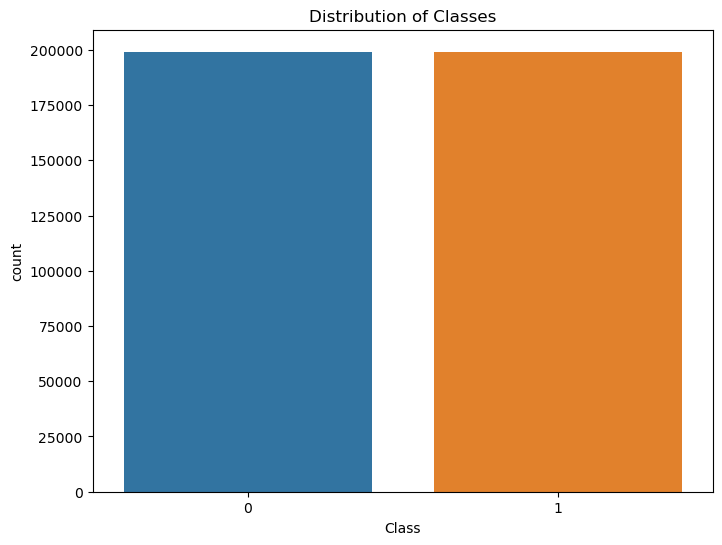

In [4]:
# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=data_train)
plt.title('Distribution of Classes')
plt.show()

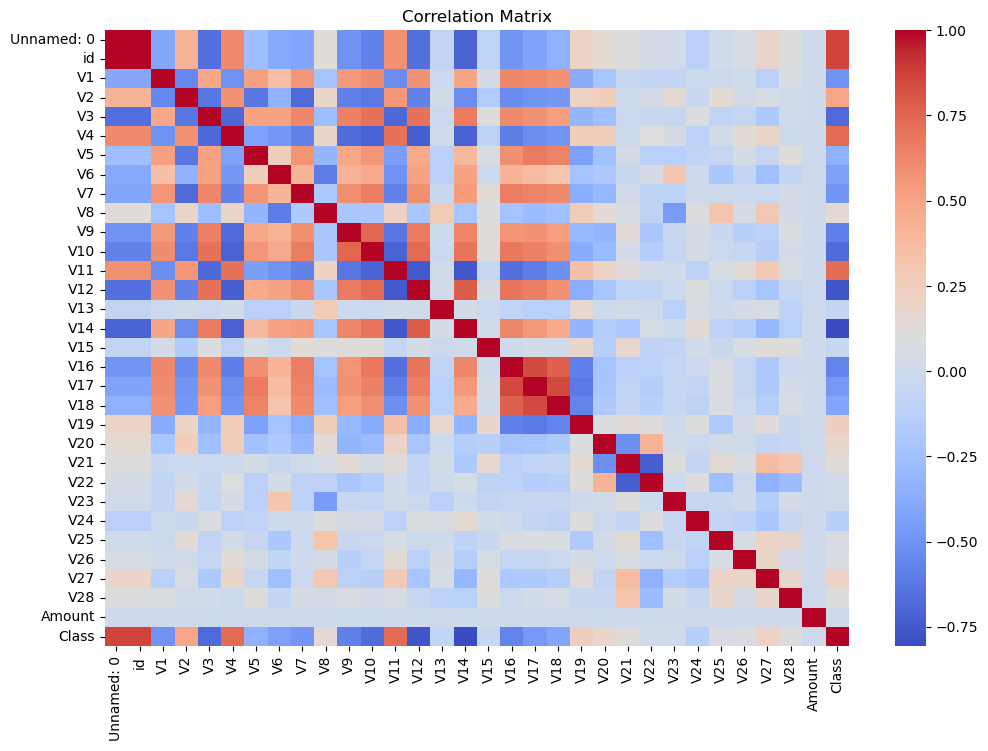

In [5]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data_train.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

In [6]:
data = data.drop(columns=["id"])
dataTrain = data.sample(frac= 0.7)
dataVal = data.drop(dataTrain.index)

In [7]:
dataTrain.reset_index(inplace= True)
dataTrain.drop(columns=["index"])

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,140701,0.967362,-0.261469,0.360247,-0.078163,0.238710,-0.130726,0.477477,-0.159624,0.580575,...,-0.118537,-0.121733,-0.057638,0.472530,0.780577,-0.743685,-0.190520,0.029829,18793.10,0
1,477357,-0.203349,-0.113602,0.227747,0.340323,-0.511302,0.846879,0.002907,-0.527555,0.088319,...,-0.384872,0.832435,0.469475,0.988547,0.370534,1.064958,0.234899,0.560231,23103.17,1
2,206801,-0.036999,-0.197217,-0.013969,-1.849675,2.019639,2.124727,0.830069,0.017905,0.287927,...,0.007679,0.642732,-0.370120,1.361707,0.367788,-0.491283,-0.183121,0.227130,8035.79,0
3,411916,-0.039411,0.210102,-0.158752,0.593908,-0.033441,0.021063,-0.154764,0.055478,-0.517353,...,0.047325,-0.427829,-0.274582,-0.693480,0.885697,0.227233,0.372690,0.610660,13440.08,1
4,562693,-0.270252,0.199397,0.009711,-0.111639,0.035850,-0.412448,-0.013651,-0.183465,-0.238306,...,0.273447,-0.018119,-0.189333,0.490625,-0.150174,-0.672391,0.355918,0.020108,11272.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278624,455214,-0.830783,-1.632348,0.531930,-0.186721,1.334476,-0.398802,0.162555,-0.532517,0.686942,...,0.065628,-0.788125,-0.603291,-0.086614,-0.289726,-1.186549,1.285013,-0.195606,7488.52,1
278625,407305,0.920949,-0.059478,0.008225,0.128169,0.649894,-0.046001,0.546488,-0.152696,0.436199,...,-0.242021,-0.638857,-0.156513,-0.409780,1.015660,-0.778531,-0.119506,0.189988,5042.92,1
278626,61742,-0.435564,-0.362543,1.389441,-0.154706,0.063663,0.889387,0.146584,0.167485,0.141112,...,0.023296,0.304861,-0.392380,-1.144697,0.024962,-0.320101,-0.438927,-0.642562,12838.51,0
278627,36969,0.016881,-0.090220,1.761101,-0.587168,0.161283,-0.245498,0.738788,-0.186987,0.177990,...,-0.177106,-0.417526,0.008792,2.038669,-0.457546,0.094571,0.089829,0.209978,18753.57,0


In [8]:
train_data = []
for i in range(len(dataTrain)):
   temp_data = dataTrain.iloc[i].drop(columns=["Class"])
   train_data.append([temp_data.to_numpy()[1:-2], dataTrain["Class"][i]])



In [9]:
dataVal.reset_index(inplace= True)
dataVal.drop(columns=["index"])

val_data = []
for i in range(len(dataVal)):
   temp_data = dataVal.iloc[i].drop(columns=["Class"])
   val_data.append([temp_data.to_numpy()[1:-2], dataVal["Class"][i]])

In [10]:
NUM_TRAIN = 49000
loader_train = DataLoader(train_data, batch_size=64, shuffle= True)
loader_val = DataLoader(val_data, batch_size=64, shuffle= True)

In [11]:
import torch.nn.functional as F

print_every = 100


def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            
            _, preds = scores.max(1)
            #print(preds)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        
def train_part34(model, optimizer, epochs=1):
    """
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            # if t == 0:
            #     print(x.shape)
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [12]:


# model = nn.Sequential(
#     nn.Linear(in_features= 29, out_features= 256),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(in_features= 256, out_features= 128),
#     nn.BatchNorm1d(num_features= 128),
#     nn.Dropout(0.5)
# )

from model.model import NeuralNetwork
model = NeuralNetwork(29)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [13]:
train_part34(model, optimizer)

Iteration 0, loss = 0.6951
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Predict and show results
def predict_and_show(model, X, y, dataset_name):
    """Make predictions and show confusion matrix, classification report, and accuracy."""
    y_pred_prob = model(X)
    y_pred = np.round(y_pred_prob)
    
    print(f'-------{dataset_name} Evaluation---------')
    print('Confusion Matrix:')
    print(confusion_matrix(y, y_pred))
    print('\nClassification Report:')
    print(classification_report(y, y_pred))
    
    accuracy = accuracy_score(y, y_pred)
    print(f'\n{dataset_name} Accuracy: {accuracy * 100:.2f}%')

In [ ]:
X_train = dataTrain.iloc[:,:-2]
y_train = dataTrain.iloc[:,-1]
X_test = dataVal.iloc[:,:-2]
y_test = dataVal.iloc[:,-1]

In [ ]:
check_accuracy_part34(loader_train, model)
#check_accuracy_part34(loader_val, model)

In [ ]:
torch.save(model.state_dict(), "model/ModelNN-CreditFraudDetection.pt")

In [ ]:
train_data

In [ ]:
data

In [ ]:
train_data

In [ ]:
next(iter(loader_train))